In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from skimage.color import gray2rgb
from skimage.segmentation import mark_boundaries

In [2]:
# get dataset and split it into two datasets (training, testing)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# preprocessing the data
def preprocess_data(X, y):
    # normalization
    X = X.astype("float32") / 255
    X = np.array([gray2rgb(img) for img in X])
    # one-hot encoding
    y = np_utils.to_categorical(y)
    return X, y

X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

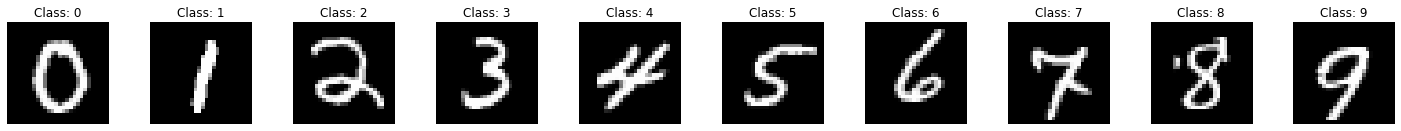

In [4]:
np.random.seed(100)

examples = []
for i in range(10):
    indexes = np.where(np.argmax(y_test, axis=1) == i)
    all_indexes = np.hstack(indexes)
    examples.append(np.random.choice(all_indexes))

# show examples
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[examples][i])
    ax.title.set_text(f'Class: {np.argmax(y_test[examples][i])}')
    ax.axis('off')

In [5]:
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


In [6]:
import keras
import tensorflow as tf

In [7]:
model = keras.Sequential(
    [
        keras.Input(shape=np.shape(X_train)[1:]),
        keras.layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),        
        keras.layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(3, 3)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0

In [9]:
model.fit(X_train, y_train, epochs=5, batch_size=20, validation_split=0.1)

Epoch 1/5
2700/2700 [==============================] - 24s 9ms/step - loss: 0.7664 - accuracy: 0.7439 - val_loss: 0.1979 - val_accuracy: 0.9500
Epoch 2/5
2700/2700 [==============================] - 24s 9ms/step - loss: 0.4428 - accuracy: 0.8600 - val_loss: 0.1263 - val_accuracy: 0.9677
Epoch 3/5
2700/2700 [==============================] - 24s 9ms/step - loss: 0.3768 - accuracy: 0.8804 - val_loss: 0.1148 - val_accuracy: 0.9682
Epoch 4/5
2700/2700 [==============================] - 21s 8ms/step - loss: 0.3475 - accuracy: 0.8898 - val_loss: 0.1066 - val_accuracy: 0.9723
Epoch 5/5
2700/2700 [==============================] - 25s 9ms/step - loss: 0.3192 - accuracy: 0.8992 - val_loss: 0.0983 - val_accuracy: 0.9733


In [10]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Test loss:", '\t', loss)
print("Test accuracy:", '\t', accuracy)

Test loss: 	 0.1094740480184555
Test accuracy: 	 0.968500018119812


### 1. LIME

In [11]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

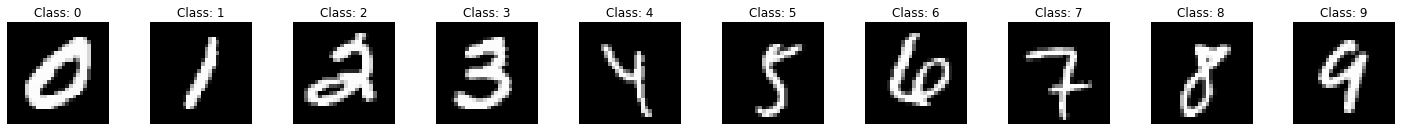

In [12]:
# images to classify and explain
np.random.seed(36)

to_classify = []
for i in range(10):
    indexes = np.where(np.argmax(y_test, axis=1) == i)
    all_indexes = np.hstack(indexes)
    to_classify.append(np.random.choice(all_indexes))

fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[to_classify][i])
    ax.title.set_text(f'Class: {np.argmax(y_test[to_classify][i])}')
    ax.axis('off')

In [13]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
explainer = lime_image.LimeImageExplainer(verbose=False)

In [ ]:
explanations = [
    explainer.explain_instance(
        X_test[to_classify][i], 
        classifier_fn=model.predict, 
        top_labels=10, 
        hide_color=0, 
        num_samples=10000,
        segmentation_fn=segmenter
    ) for i in range(10)
]

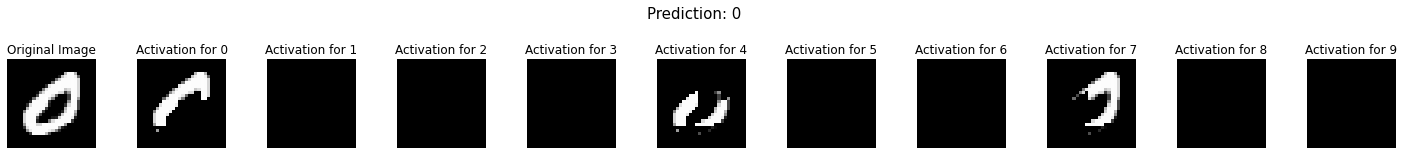

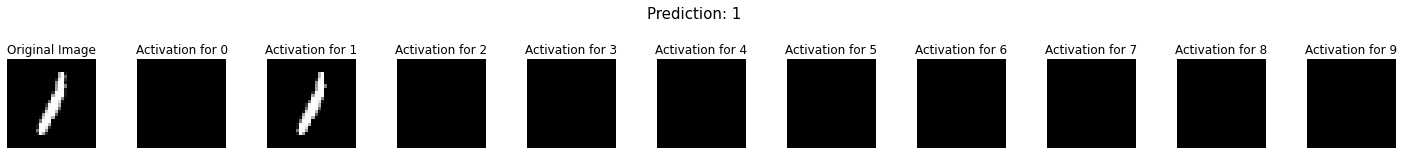

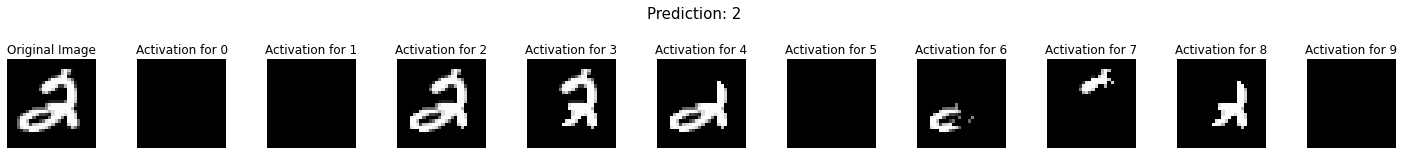

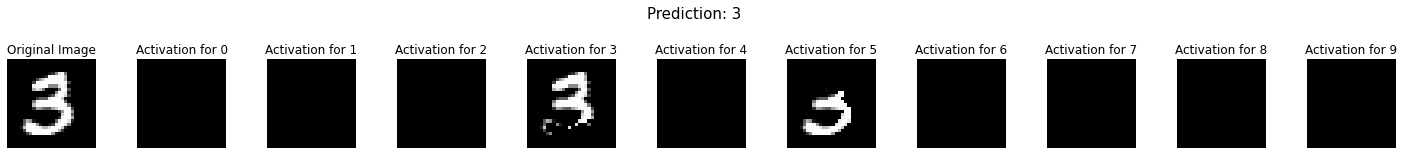

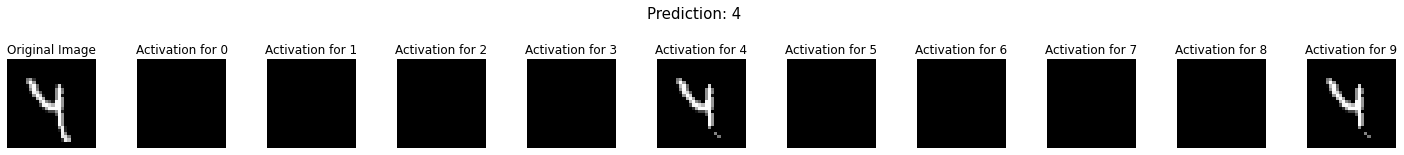

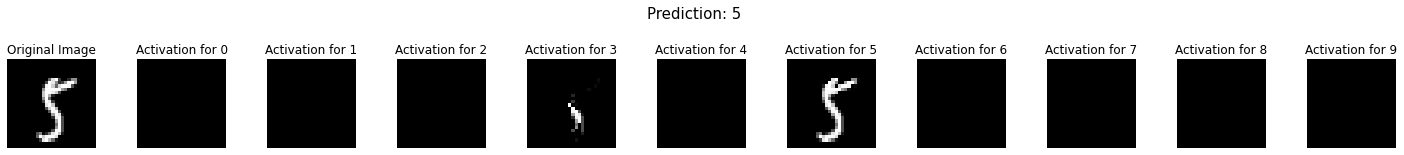

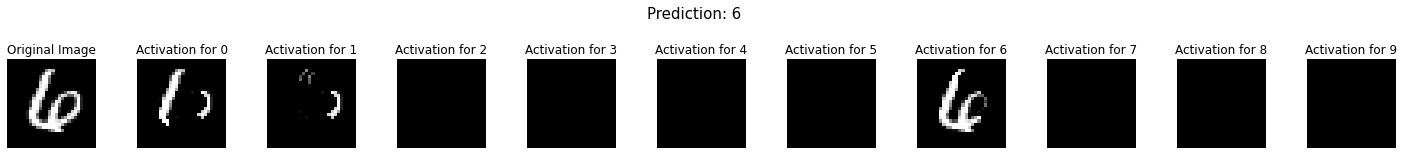

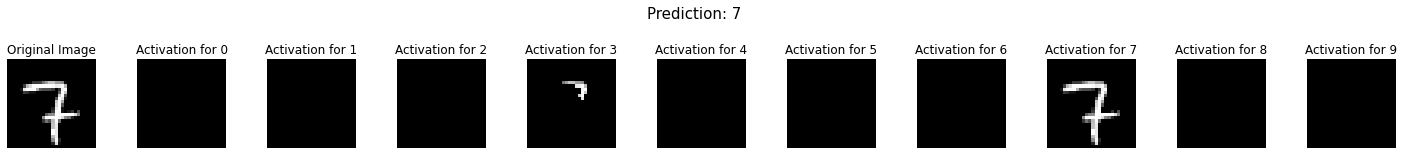

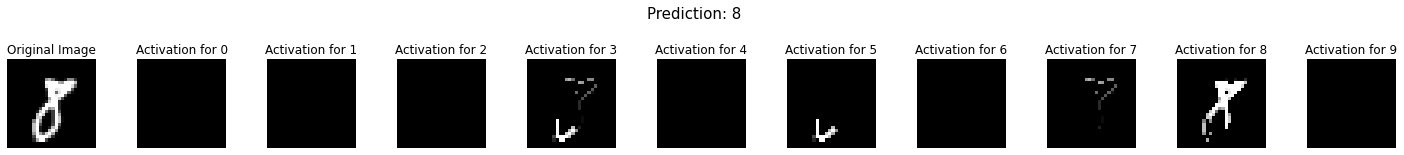

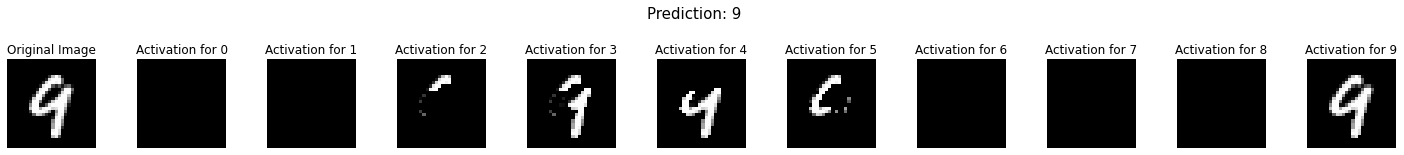

In [77]:
for i_exp, explanation in enumerate(explanations):
    fig, axes = plt.subplots(1, 11, figsize=(20, 3))
    fig.tight_layout()
    for i, c_ax in enumerate(axes.flatten()):
        if i == 0:
            c_ax.imshow(X_test[to_classify][i_exp])
            c_ax.set_title(f'Original Image')
            c_ax.axis('off')
        else:
            temp, mask = explanation.get_image_and_mask(i - 1, positive_only=True, hide_rest=True, min_weight=0.02)
            c_ax.imshow(temp)
            c_ax.set_title(f'Activation for {i - 1}')
            c_ax.axis('off')
    fig.suptitle(f'Prediction: {explanation.top_labels[0]}', fontsize=15)